In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns 
import xgboost as xgb
import time

%matplotlib inline

In [2]:
productos = pd.read_excel('producto_tabla.xlsx')
town= pd.read_excel('town_state_small.xlsx')
cliente = pd.read_excel('cliente_tabla.xlsx')

train = pd.read_csv('df_[candidate]_small.csv')
display(train.head())
display(productos.head())
display(town.head())
display(cliente.head())

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


,Producto_ID,NombreProducto
0,0,NO IDENTIFICADO 0
1,9,Capuccino Moka 750g NES 9
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41
3,53,Burritos Sincro 170g CU LON 53
4,72,Div Tira Mini Doradita 4p 45g TR 72


,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE
3,3,EL MORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT


In [3]:
train['Semana'].value_counts()

3    1433867
4    1403083
8    1340437
7    1295245
5    1281147
6    1220639
Name: Semana, dtype: int64

In [4]:
test = pd.read_csv('df_[test]_small.csv')

In [5]:
test['Semana'].value_counts()

9    1337913
Name: Semana, dtype: int64

## Analisis tabla producto
### Split NombreProducto into 4 new features

In [6]:
productos['Producto'] = productos['NombreProducto'].str.extract('^(\D*)', expand = False)
productos['Piezas'] = productos['NombreProducto'].str.extract('(\d+)p ', expand = False).astype(float)
peso = productos['NombreProducto'].str.extract('(\d+)(Kg|g)', expand = True)
productos['Peso'] = peso[0].astype('float') * peso[1].map({'Kg': 1000, 'g': 1})
productos['Marca'] = productos['NombreProducto'].str.extract('^.+\s(\D+) \d+$')
productos.head()

,Producto_ID,NombreProducto,Producto,Piezas,Peso,Marca
0,0,NO IDENTIFICADO 0,NO IDENTIFICADO,NaN,NaN,IDENTIFICADO
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,NaN,750.0,NES
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,6.0,480.0,BIM
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,NaN,170.0,LON
4,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,4.0,45.0,TR


In [7]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("spanish")

# Remove stopwords
productos['Producto'] = (productos['Producto'].map(lambda x: " ".join([i for i in x.lower()
                                                            .split() if i not in stopwords.words("spanish")])))

# Remove stemwords
#productos['Producto'] = (productos['Producto'].map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))

productos.head()

,Producto_ID,NombreProducto,Producto,Piezas,Peso,Marca
0,0,NO IDENTIFICADO 0,identificado,NaN,NaN,IDENTIFICADO
1,9,Capuccino Moka 750g NES 9,capuccino moka,NaN,750.0,NES
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,bimbollos ext sajonjoli,6.0,480.0,BIM
3,53,Burritos Sincro 170g CU LON 53,burritos sincro,NaN,170.0,LON
4,72,Div Tira Mini Doradita 4p 45g TR 72,div tira mini doradita,4.0,45.0,TR


In [8]:
print('Shape Before Merge: ' + str(train.shape))
train = train.merge(productos, on = ['Producto_ID'], how = 'left')
print('Shape After Merge: ' + str(train.shape))
train.head()

Shape Before Merge: (7974418, 11)
Shape After Merge: (7974418, 16)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,NombreProducto,Producto,Piezas,Peso,Marca
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3,Roles Canela 2p 120g BIM 1212,roles canela,2.0,120.0,BIM
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4,Roles Glass 2p 135g BIM 1216,roles glass,2.0,135.0,BIM
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4,Panquecito Gota Choc 2p 140g BIM 1238,panquecito gota choc,2.0,140.0,BIM
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4,Mantecadas Vainilla 4p 125g BIM 1240,mantecadas vainilla,4.0,125.0,BIM
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3,Donitas Espolvoreadas 6p 105g BIM 1242,donitas espolvoreadas,6.0,105.0,BIM


In [9]:
columns = ['short_product_name', 'Demanda_uni_equil']
mas_vendidos = pd.DataFrame({'Adjusted_Sales': train.groupby(['Producto'])['Demanda_uni_equil'].sum()}).reset_index()

In [10]:
mas_vendidos = mas_vendidos.sort_values(by = ['Adjusted_Sales'], ascending = False)
print(mas_vendidos.head(n=10))

print('')
print('Unique Product Ids: ' + str(len(train['Producto_ID'].unique())))
print('Unique short product names: ' + str(len(train['Producto'].unique())))
print('Top Seller as Percentage of All Sales: ' + str(100.0 * mas_vendidos['Adjusted_Sales'][0] / mas_vendidos['Adjusted_Sales'].sum()))

                 Producto  Adjusted_Sales
197                  nito         4662729
325           tortillinas         3013353
262              rebanada         2897285
114          donas azucar         2761941
203            pan blanco         2453330
169             madalenas         2260185
211          pan integral         2136043
154               gansito         2011036
176   mantecadas vainilla         1644157
246  polvoroncitos panera         1615636

Unique Product Ids: 710
Unique short product names: 363
Top Seller as Percentage of All Sales: 0.11175631257253725


## Analisis tabla cliente

Se analiza la posibilidad de generar una nueva varible a partir del cliente, se busca clasificar al cliente segun un tipo de cliente

In [11]:
# Remove duplicate ids
def remove_duplicate_ids(clients): 
    """ Finds and removes duplicate ids from client data. Returns cleaned data.
    """
    duplicate_ids = clients.duplicated(subset = 'Cliente_ID')    
    clients = clients[duplicate_ids == False]    
    return clients

clients = remove_duplicate_ids(cliente)  

In [12]:
print('# Cliente_ID unicos: ' + str(len(clients['Cliente_ID'].unique())))
print('# Unique NombreCliente unicos: ' + str(len(clients['NombreCliente'].unique())))

# Cliente_ID unicos: 930500
# Unique NombreCliente unicos: 307009


In [13]:
clients.head()

,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE
3,3,EL MORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT


In [14]:
clients['Client_Type'] = clients['NombreCliente'].str.lower()
clients.head()

<ipython-input-14-90019e3589f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clients['Client_Type'] = clients['NombreCliente'].str.lower()


,Cliente_ID,NombreCliente,Client_Type
0,0,SIN NOMBRE,sin nombre
1,1,OXXO XINANTECATL,oxxo xinantecatl
2,2,SIN NOMBRE,sin nombre
3,3,EL MORENO,el moreno
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT,sdn ser de alim cuerpo sa cia de int


In [15]:
clients['NombreCliente'].value_counts()[0:200]

NO IDENTIFICADO    281670
LUPITA               4863
MARY                 3016
LA PASADITA          2426
LA VENTANITA         2267
                    ...  
ORTIZ                 239
LA CURVA              238
RIVERA                238
TANIA                 238
JUAREZ                236
Name: NombreCliente, Length: 200, dtype: int64

In [16]:
clients['NombreCliente']

0                                      SIN NOMBRE
1                                OXXO XINANTECATL
2                                      SIN NOMBRE
3                                       EL MORENO
4         SDN SER  DE ALIM  CUERPO SA CIA  DE INT
                           ...                   
935357                                 OXXO PETEN
935358                       SUPER ABARROTES MARY
935359                            NO IDENTIFICADO
935360                            NO IDENTIFICADO
935361                            NO IDENTIFICADO
Name: NombreCliente, Length: 930500, dtype: object

In [17]:
import re
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
# Remove stop words
nombre_tokenized = [word_tokenize(str(x)) for x in clients['Client_Type']]
stops = set(stopwords.words("spanish"))
nombre_cleaned = [[w for w in i if not w in stops] for i in nombre_tokenized] 
nombre_cleaned = [" ".join(x) for x in nombre_cleaned]  
nombre_cleaned[0:30]

['nombre',
 'oxxo xinantecatl',
 'nombre',
 'moreno',
 'sdn ser alim cuerpo sa cia int',
 'vaquita',
 'lupita',
 'i m guero',
 'mini super lupes',
 'super kompras micro colon',
 'lonja mercantil',
 'farmacia nicolas san juan',
 'papeleria catala',
 'elena',
 'casa trino',
 'fma035947 bimbo sa cv',
 'joys',
 'marco',
 'lupes ii',
 'tiendita',
 'fma026712 tecnoautomotriz atlacomulco s',
 'abarrotes ivan',
 'garnica',
 'fma026709 bucirus bladas mexico sa',
 'fma026248 proveedora norte',
 'carrosita',
 'bodega comercial mexicana toluca',
 'marquez',
 'fma033097 automotriz mexicana s c',
 'jose aguilar catalan']

In [18]:
words = ['oxxo', 'abarrotes', 'super','wal mart','hospital','conasupo','bimbo','farmacia','colegio','aurrera','comercial','soriana','mart']
for word in words: 
    print(word + ' : ')
    nombre_contains = [(word in x) for x in nombre_cleaned]  
    indices = [n for n, x in enumerate(nombre_contains) if x == True]  
    temp = [nombre_cleaned[i] for i in indices]
    print(temp[0:20])    
    print('# Names Appears: ' + str(len(indices)))
    print('')

oxxo : 
['oxxo xinantecatl', 'oxxo san carlos', 'oxxo mora', 'oxxo 5 mayo', 'oxxo san sebastian', 'oxxo san javier', 'oxxo carranza', 'oxxo padre mier', 'amoxxo bernardo reyes', 'oxxo tapia', 'oxxo madero terminal', 'oxxo cintermex', 'oxxo pino suarez ii', 'oxxo ruperto martinez', 'oxxo regina', 'oxxo satelite', 'oxxo mederos', 'oxxo condominio', 'oxxo estanzuela 1', 'oxxo prado']
# Names Appears: 9276

abarrotes : 
['abarrotes ivan', 'vinos abarrotes jose', 'abarrotes lupita', 'dulceria abarrotes m t', 'super abarrotes', 'abarrotes profe', 'abarrotes rosario', 'tortilleria abarrotes lourdes', 'abarrotestianguistecanos s c v', 'abarrotes monarca', 'abarrotes ramon ortiz', 'abarrotes chavez', 'abarrotes ballon', 'abarrotes rancho', 'abarrotes elizabeth', 'abarrotes lumbreras', 'abarrotes pesadita', 'abarrotes garza', 'abarrotes licha', 'abarrotes vicky']
# Names Appears: 32871

super : 
['mini super lupes', 'super kompras micro colon', 'super kompras pino suarez', 'super kompras san bue

In [19]:
lista= ['Walmart', 'Oxxo', 'Conasupo','Expendio de Bimbo','Escuela','Hospital/Farmacia','Restaurantes','Supermercados','Mercados gral','Hotel']

In [20]:
def create_client_features(clients):
    
    
    # Known Large Company / Special Group Types
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*wal mart*','.*sams club.*'],'Walmart', regex=True)
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.replace('.*oxxo.*','Oxxo')
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.replace('.*conasupo.*','Conasupo')
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.replace('.*bimbo.*','Expendio de Bimbo')
    
    # Term search for assortment of words picked from looking at their frequencies
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*coleg.*','.*univ.*','.*escu.*','.*insti.*',\
                                                        '.*prepa.*'],'Escuela', regex=True)
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*farma.*','.*hospital.*','.*clini.*'],'Hospital/Farmacia', regex=True)
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*cafe.*','.*dulceria.*',\
                                                        '.*rest.*','.*hambur.*','.*taco.*', '.*torta.*',\
                                                        '.*taquer.*'],'Restaurantes', regex=True)
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*super.*','.*mexicana.*','.*soriana.*'],'Supermercados')
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*deposito.*',\
                                                            '.*abarrotes.*','.*mercado.*','.*cambio.*',\
                                                        '.*MARKET.*','.*six.*','.*mini .*',\
                                                        '.*plaza.*','.*misc.*','.*eleven.*','.*exp.*',\
                                                         '.*snack.*', '.*papeleria.*', '.*carniceria.*',\
                                                         '.*local.*','.*verdu.*','.*frut.*'],'Mercados gral'\
                                                       , regex=True)                                                   
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*hotel.*','.*motel.*'],'Hotel', regex=True)    
 
                  
    # Everything else bucketed into 'Individual'
        
    
    # Return data
    return clients

In [21]:
clients = create_client_features(clients)
clients.head()

/home/ivandelarosa/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-20-986fbc7163c8>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.replace('.*oxxo.*','Oxxo')
<ipython-input-20-986fbc7163c8>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.replace('.*conasupo.*','Conasupo')
<ipython-input-20-986fbc7163c8>:8: FutureWarning: The default value of regex will change from True to False in a futur

,Cliente_ID,NombreCliente,Client_Type
0,0,SIN NOMBRE,sin nombre
1,1,OXXO XINANTECATL,Oxxo
2,2,SIN NOMBRE,sin nombre
3,3,EL MORENO,el moreno
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT,sdn ser de alim cuerpo sa cia de int


In [22]:
clients['Client_Type'].loc[~clients.loc[:,'Client_Type'].isin(lista)]='Otros'



/home/ivandelarosa/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/ivandelarosa/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [23]:
clients

,Cliente_ID,NombreCliente,Client_Type
0,0,SIN NOMBRE,Otros
1,1,OXXO XINANTECATL,Oxxo
2,2,SIN NOMBRE,Otros
3,3,EL MORENO,Otros
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT,Otros
...,...,...,...
935357,11011586,OXXO PETEN,Oxxo
935358,11693264,SUPER ABARROTES MARY,Mercados gral
935359,19988629,NO IDENTIFICADO,Otros
935360,99999999,NO IDENTIFICADO,Otros


In [24]:
clients['Client_Type'].value_counts()

Otros                825318
Mercados gral         72008
Restaurantes          10009
Oxxo                   9276
Escuela                5708
Hospital/Farmacia      5699
Hotel                  1128
Conasupo                958
Expendio de Bimbo       319
Walmart                  77
Name: Client_Type, dtype: int64

In [25]:
print('Shape Before Merge: ' + str(train.shape))
train = train.merge(clients, on = 'Cliente_ID', how = 'left')
print('Shape After Merge: ' + str(train.shape))
train.head()

Shape Before Merge: (7974418, 16)
Shape After Merge: (7974418, 18)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,NombreProducto,Producto,Piezas,Peso,Marca,NombreCliente,Client_Type
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3,Roles Canela 2p 120g BIM 1212,roles canela,2.0,120.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4,Roles Glass 2p 135g BIM 1216,roles glass,2.0,135.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4,Panquecito Gota Choc 2p 140g BIM 1238,panquecito gota choc,2.0,140.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4,Mantecadas Vainilla 4p 125g BIM 1240,mantecadas vainilla,4.0,125.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3,Donitas Espolvoreadas 6p 105g BIM 1242,donitas espolvoreadas,6.0,105.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros


In [26]:
best_selling_types = pd.DataFrame({'Adjusted Sales': train.groupby(['Client_Type'])['Demanda_uni_equil'].sum()}).reset_index()
best_selling_types['Pct'] = 100.0 * best_selling_types['Adjusted Sales'] / best_selling_types['Adjusted Sales'].sum()
best_selling_types = best_selling_types.sort_values(by = 'Adjusted Sales', ascending = False)
best_selling_types

,Client_Type,Adjusted Sales,Pct
6,Otros,52080627,87.546272
5,Mercados gral,4031547,6.776933
7,Oxxo,1910641,3.211741
1,Escuela,460549,0.774172
8,Restaurantes,382458,0.642903
9,Walmart,260017,0.437082
3,Hospital/Farmacia,236683,0.397858
2,Expendio de Bimbo,69484,0.116801
0,Conasupo,35532,0.059728
4,Hotel,21719,0.036509


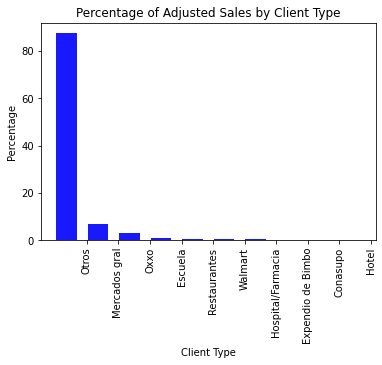

In [27]:
n_groups = len(best_selling_types['Client_Type'])
groups = best_selling_types['Client_Type']
pcts = best_selling_types['Pct']
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.65
opacity = 0.9

rects1 = plt.bar(index, pcts, bar_width,
                 alpha=opacity,
                 color='b')

plt.xlabel('Client Type')
plt.ylabel('Percentage')
plt.title('Percentage of Adjusted Sales by Client Type')
plt.xticks(index + bar_width, groups, rotation = 'vertical')
plt.show()

In [28]:
mas_vendidos.head(n=2)

,Producto,Adjusted_Sales
197,nito,4662729
325,tortillinas,3013353


In [29]:
products = mas_vendidos['Producto'][0:2]
best_selling_products = pd.DataFrame({'Adjusted Sales': train.loc[train['Producto'].isin(products)].groupby(
            ['Client_Type', 'Producto'])['Demanda_uni_equil'].sum()}).reset_index()
best_selling_products

,Client_Type,Producto,Adjusted Sales
0,Conasupo,nito,3125
1,Conasupo,tortillinas,1247
2,Escuela,nito,26770
3,Escuela,tortillinas,19236
4,Expendio de Bimbo,nito,835
5,Expendio de Bimbo,tortillinas,641
6,Hospital/Farmacia,nito,14154
7,Hospital/Farmacia,tortillinas,8166
8,Hotel,nito,25
9,Hotel,tortillinas,2602


In [30]:
best_selling_products['Pct'] = 100.0 * best_selling_products['Adjusted Sales']
unique_products = list(best_selling_products['Producto'].unique())
for product in unique_products: 
    product_sum = mas_vendidos.loc[mas_vendidos['Producto'] == product, 'Adjusted_Sales'].sum()
    best_selling_products.loc[best_selling_products['Producto'] == product, 'Pct'] /= 1.0 * product_sum
best_selling_products

,Client_Type,Producto,Adjusted Sales,Pct
0,Conasupo,nito,3125,0.067021
1,Conasupo,tortillinas,1247,0.041382
2,Escuela,nito,26770,0.574127
3,Escuela,tortillinas,19236,0.638359
4,Expendio de Bimbo,nito,835,0.017908
5,Expendio de Bimbo,tortillinas,641,0.021272
6,Hospital/Farmacia,nito,14154,0.303556
7,Hospital/Farmacia,tortillinas,8166,0.270994
8,Hotel,nito,25,0.000536
9,Hotel,tortillinas,2602,0.086349


In [31]:
n_groups = len(best_selling_types['Client_Type'])
groups = best_selling_types['Client_Type']

pcts = best_selling_products.loc[best_selling_products['Producto'] == 'nito', 'Pct'].sort_values(ascending = False)
pcts2 = best_selling_products.loc[best_selling_products['Producto'] == 'tortillinas', 'Pct'].sort_values(ascending = False)
#pcts3 = best_selling_products.loc[best_selling_products['Producto'] == 'reban', 'Pct'].sort_values(ascending = False)



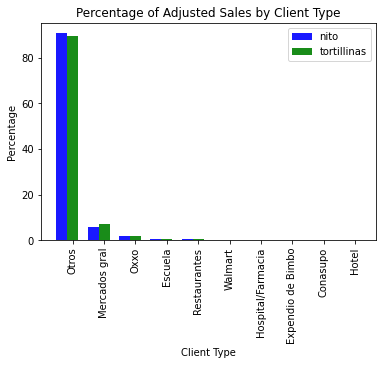

In [32]:
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.9

rects1 = plt.bar(index[0:9], pcts, bar_width,
                 alpha=opacity,
                 color='b',
                 label='nito')

rects2 = plt.bar(index + bar_width, pcts2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='tortillinas')

plt.xlabel('Client Type')
plt.ylabel('Percentage')
plt.title('Percentage of Adjusted Sales by Client Type')
plt.xticks(index + bar_width, groups, rotation = 'vertical')
plt.legend()

#plt.tight_layout()
plt.show()

## Tabla town

In [33]:
print('Shape Before Merge: ' + str(train.shape))
train = train.merge(town, on = 'Agencia_ID', how = 'left')
print('Shape After Merge: ' + str(train.shape))
train.head()

Shape Before Merge: (7974418, 18)
Shape After Merge: (7974418, 20)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,NombreProducto,Producto,Piezas,Peso,Marca,NombreCliente,Client_Type,Town,State
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3,Roles Canela 2p 120g BIM 1212,roles canela,2.0,120.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4,Roles Glass 2p 135g BIM 1216,roles glass,2.0,135.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4,Panquecito Gota Choc 2p 140g BIM 1238,panquecito gota choc,2.0,140.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4,Mantecadas Vainilla 4p 125g BIM 1240,mantecadas vainilla,4.0,125.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3,Donitas Espolvoreadas 6p 105g BIM 1242,donitas espolvoreadas,6.0,105.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."


## Matriz de correlación

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7974418 entries, 0 to 7974417
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Semana             int64  
 1   Agencia_ID         int64  
 2   Canal_ID           int64  
 3   Ruta_SAK           int64  
 4   Cliente_ID         int64  
 5   Producto_ID        int64  
 6   Venta_uni_hoy      int64  
 7   Venta_hoy          float64
 8   Dev_uni_proxima    int64  
 9   Dev_proxima        float64
 10  Demanda_uni_equil  int64  
 11  NombreProducto     object 
 12  Producto           object 
 13  Piezas             float64
 14  Peso               float64
 15  Marca              object 
 16  NombreCliente      object 
 17  Client_Type        object 
 18  Town               object 
 19  State              object 
dtypes: float64(4), int64(9), object(7)
memory usage: 1.2+ GB


In [35]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))
missing_data(train)

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,NombreProducto,Producto,Piezas,Peso,Marca,NombreCliente,Client_Type,Town,State
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,2993460,85063,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.538288,1.066699,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,int64,int64,int64,int64,int64,float64,int64,float64,int64,object,object,float64,float64,object,object,object,object,object


In [36]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Semana,7974418.0,5.446631e+00,1.735310e+00,3.0,4.00,5.00,7.0,8.0
Agencia_ID,7974418.0,1.126474e+03,1.243164e+01,1110.0,1118.00,1123.00,1130.0,1173.0
Canal_ID,7974418.0,1.269744e+00,1.039153e+00,1.0,1.00,1.00,1.0,11.0
Ruta_SAK,7974418.0,1.827039e+03,1.276917e+03,1.0,1201.00,1433.00,1625.0,9988.0
Cliente_ID,7974418.0,1.426347e+06,1.522097e+06,3967.0,324288.00,871131.00,2104284.0,99999999.0
Producto_ID,7974418.0,1.499695e+04,1.769279e+04,53.0,1220.00,2233.00,34212.0,49994.0
Venta_uni_hoy,7974418.0,7.534587e+00,2.206313e+01,0.0,2.00,4.00,7.0,4800.0
Venta_hoy,7974418.0,8.140738e+01,5.859644e+02,0.0,18.86,34.59,65.4,647360.0
Dev_uni_proxima,7974418.0,1.044087e-01,3.211733e+00,0.0,0.00,0.00,0.0,3360.0
Dev_proxima,7974418.0,1.209538e+00,2.832457e+01,0.0,0.00,0.00,0.0,49500.0


array([[<AxesSubplot:title={'center':'Semana'}>,
        <AxesSubplot:title={'center':'Agencia_ID'}>,
        <AxesSubplot:title={'center':'Canal_ID'}>,
        <AxesSubplot:title={'center':'Ruta_SAK'}>],
       [<AxesSubplot:title={'center':'Cliente_ID'}>,
        <AxesSubplot:title={'center':'Producto_ID'}>,
        <AxesSubplot:title={'center':'Venta_uni_hoy'}>,
        <AxesSubplot:title={'center':'Venta_hoy'}>],
       [<AxesSubplot:title={'center':'Dev_uni_proxima'}>,
        <AxesSubplot:title={'center':'Dev_proxima'}>,
        <AxesSubplot:title={'center':'Demanda_uni_equil'}>,
        <AxesSubplot:title={'center':'Piezas'}>],
       [<AxesSubplot:title={'center':'Peso'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

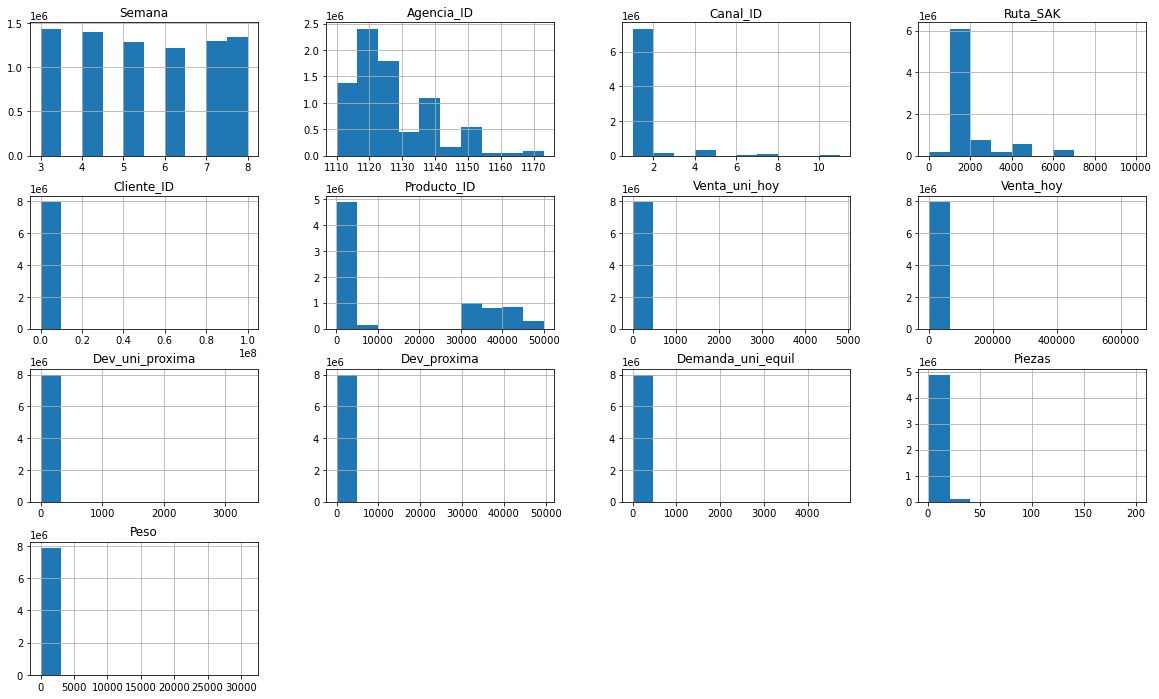

In [37]:
train.hist(figsize=(20,12))

<AxesSubplot:>

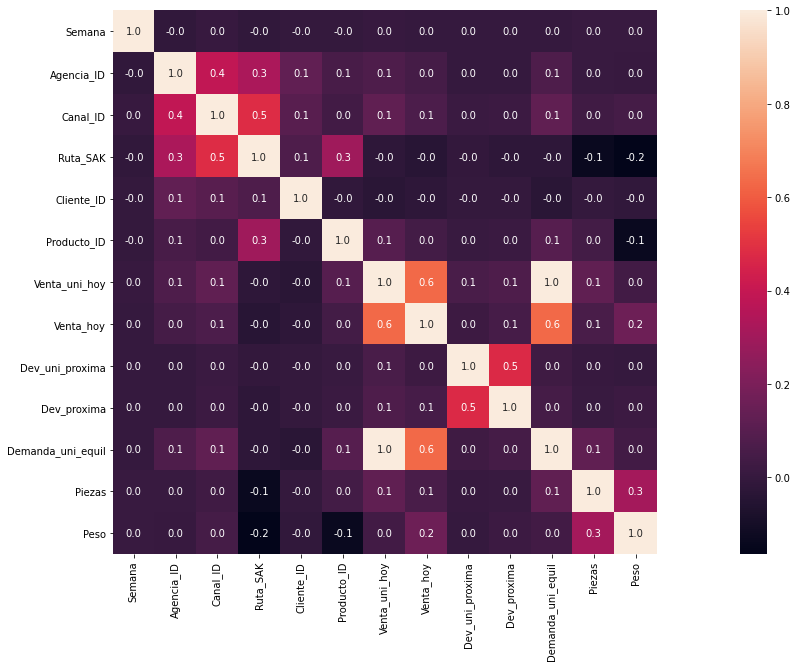

In [38]:
correlation = train.corr()
plt.subplots(figsize=(30,10))
sns.heatmap(correlation, square=True, annot=True, fmt=".1f" )

In [39]:
print('Shape Before Merge: ' + str(test.shape))
test = test.merge(productos, on = ['Producto_ID'], how = 'left')
test = test.merge(clients, on = 'Cliente_ID', how = 'left')
test = test.merge(town, on = 'Agencia_ID', how = 'left')
print('Shape After Merge: ' + str(test.shape))
test.head()

Shape Before Merge: (1337913, 6)
Shape After Merge: (1337913, 15)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,NombreProducto,Producto,Piezas,Peso,Marca,NombreCliente,Client_Type,Town,State
0,9,1110,7,3301,15766,1212,Roles Canela 2p 120g BIM 1212,roles canela,2.0,120.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,9,1110,7,3301,15766,1238,Panquecito Gota Choc 2p 140g BIM 1238,panquecito gota choc,2.0,140.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
2,9,1110,7,3301,15766,1240,Mantecadas Vainilla 4p 125g BIM 1240,mantecadas vainilla,4.0,125.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
3,9,1110,7,3301,15766,1242,Donitas Espolvoreadas 6p 105g BIM 1242,donitas espolvoreadas,6.0,105.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,9,1110,7,3301,15766,1250,Donas Azucar 4p 105g BIM 1250,donas azucar,4.0,105.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."


In [40]:
train1=train.drop(['NombreCliente','NombreProducto','Venta_uni_hoy','Venta_hoy','Dev_uni_proxima','Dev_proxima'], axis=1)
test1=test.drop(['NombreCliente','NombreProducto'], axis=1)



In [41]:
train1.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,Producto,Piezas,Peso,Marca,Client_Type,Town,State
0,3,1110,7,3301,15766,1212,3,roles canela,2.0,120.0,BIM,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,3,1110,7,3301,15766,1216,4,roles glass,2.0,135.0,BIM,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
2,3,1110,7,3301,15766,1238,4,panquecito gota choc,2.0,140.0,BIM,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
3,3,1110,7,3301,15766,1240,4,mantecadas vainilla,4.0,125.0,BIM,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,3,1110,7,3301,15766,1242,3,donitas espolvoreadas,6.0,105.0,BIM,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."


In [42]:
from sklearn.preprocessing import LabelEncoder
# creating initial dataframe

# creating instance of labelencoder
labelencoder = LabelEncoder()
labelencoder2 = LabelEncoder()
labelencoder3 = LabelEncoder()
labelencoder4 = LabelEncoder()
labelencoder5 = LabelEncoder()



# Assigning numerical values and storing in another column
train1['Producto'] = labelencoder.fit_transform(train1['Producto'])
test1['Producto'] = labelencoder.fit_transform(test1['Producto'])
train1['Client_Type'] = labelencoder2.fit_transform(train1['Client_Type'])
test1['Client_Type'] = labelencoder2.fit_transform(test1['Client_Type'])
train1['Marca'] = labelencoder3.fit_transform(train1['Marca'])
test1['Marca'] = labelencoder3.fit_transform(test1['Marca'])
train1['Town'] = labelencoder4.fit_transform(train1['Town'])
test1['Town'] = labelencoder4.fit_transform(test1['Town'])
train1['State'] = labelencoder5.fit_transform(train1['State'])
test1['State'] = labelencoder5.fit_transform(test1['State'])
train1

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,Producto,Piezas,Peso,Marca,Client_Type,Town,State
0,3,1110,7,3301,15766,1212,3,264,2.0,120.0,1,6,5,2
1,3,1110,7,3301,15766,1216,4,265,2.0,135.0,1,6,5,2
2,3,1110,7,3301,15766,1238,4,232,2.0,140.0,1,6,5,2
3,3,1110,7,3301,15766,1240,4,176,4.0,125.0,1,6,5,2
4,3,1110,7,3301,15766,1242,3,117,6.0,105.0,1,6,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7974413,8,1173,4,6609,4549706,1242,2,117,6.0,105.0,1,6,3,0
7974414,8,1173,4,6609,4549706,5310,12,154,NaN,50.0,7,6,3,0
7974415,8,1173,4,6609,4549706,40447,10,325,12.0,310.0,15,6,3,0
7974416,8,1173,4,6609,4549706,40450,18,325,22.0,570.0,15,6,3,0


<AxesSubplot:>

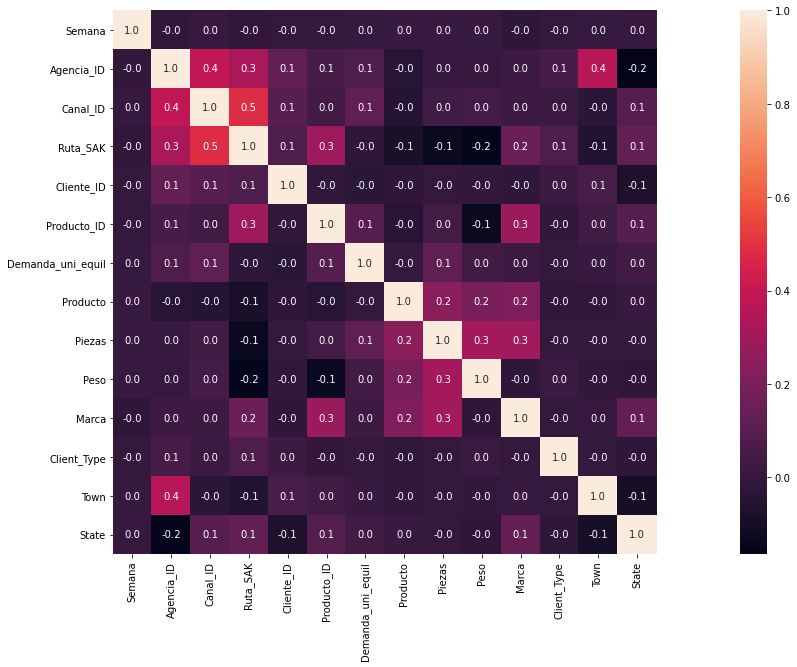

In [43]:
correlation = train1.corr()
plt.subplots(figsize=(30,10))
sns.heatmap(correlation, square=True, annot=True, fmt=".1f" )

## Modelado y Resolucion de preguntas

### 1) Justify the election of the algorithm you used

### 2) Graph a time series for a determined product-client-agency combination



In [44]:
time_s= train.loc[(train['Agencia_ID'] == 1110) & (train['Cliente_ID'] == 15766) & (train['Producto_ID']==1212)]
time_s= time_s.loc[:,['Semana','Demanda_uni_equil']]
time_s


,Semana,Demanda_uni_equil
0,3,3
1433869,4,4
2836950,5,5
6633981,8,4


In [45]:
time_s.set_index('Semana',inplace = True)

<AxesSubplot:xlabel='Semana'>

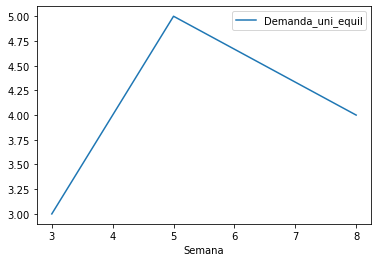

In [46]:
time_s.plot()

### 3) Add several metrics of your choice to show the robustness of the algorithm

In [47]:
def RMSLE(actuals, predictions):
    """ Takes true values and predictions. Returns their Root Mean Squared Logarithmic Error.
    """
    result = 0.0
    actuals = np.asarray(actuals) * 1.0
    predictions = np.asarray(predictions)
    if(len(actuals) == len(predictions)):
        result = np.sqrt(sum(((np.log(predictions + 1.0) - np.log(actuals + 1.0)) ** 2) / len(actuals)))
        return result
    else: 
        return "Error!"

In [48]:
def prepare_data(train, test, cv_index):
    """ Divide train data into training data for model and a hold-out validation set
        based on Semana value (can take 6, 7, 8, 9 as values). 
        
        Splits outcome variable from data for model.
        
        Converts and returns dataframes as numpy matrices.
    """
    # Reset data indices
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)       
      
    # Get CV indices from train (Semana == cv_index)
    cv_indices = train[train['Semana'] == cv_index].index
    train_indices = train[train['Semana'] != cv_index].index
    
    # Data for model building
    column_names = list(train.drop(['Demanda_uni_equil'], axis = 1).columns)
    y_train = train.loc[train_indices, 'Demanda_uni_equil'].values
    X_train = train.loc[train_indices, :].drop(['Demanda_uni_equil'], axis = 1).values
    y_validation = train.loc[cv_indices, 'Demanda_uni_equil'].values
    X_validation = train.loc[cv_indices, :].drop(['Demanda_uni_equil'], axis = 1).values
    
    # Return data
    return y_train, X_train, y_validation, X_validation, column_names

In [49]:
cv_index = 8
y_train, X_train, y_validation, X_validation, column_names = prepare_data(train1, test1, cv_index)


### Define XGBOOST model and parameters


In [ ]:
# Debido a falta de cmpouto no se efectuo la hiperparameter tunnning
'''from sklearn.model_selection import RandomizedSearchCV 

xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [5]}

xgb_grid = RandomizedSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train,
        
        verbose=True) # Change verbose to True if you want to see it train
xgb_grid.best_estimator_'''

Fitting 2 folds for each of 9 candidates, totalling 18 fits


/home/ivandelarosa/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [50]:
xgb_params = {
             'objective': 'reg:squarederror'
             , 'n_estimators': 25 
             , 'learning_rate': 0.25 
             , 'max_depth': 12 
             , 'seed': 0
             }
model_xgb = xgb.XGBRegressor()                
model_xgb.set_params(**xgb_params)   

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.25, max_delta_step=None, max_depth=12,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=25, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=0, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

### Create function to plot XGBOOST learning curves during fitting process

In [51]:
def plot_learning_curves(model_xgb):
    """ Takes XGBOOST model fit on data. 
        Plots train and validation RMSE for each iteration of model.
    """
    # Retrieve model performance metrics
    results = model_xgb.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    # Plot RMSE
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE Performance')
    plt.show()

### Create function to display XGBOOST feature importance scores

In [52]:
def feature_importance_scores(model_xgb, column_names, cv_index, cv_score): 
    """ Takes fit XGBOOST model, column names, validation set index, and validation RMSLE score as inputs. 
        Plot and saves XGBOOST feature importance scores.
    """
    # Create dataframe of feature importance scores
    fscore = model_xgb.booster().get_fscore()
    feature_importances = []
    for ft, score in fscore.iteritems(): 
        ft = column_names[int(re.sub("[^0-9]","", ft))]
        feature_importances.append({'Feature': ft, 'Importance': score})
    feature_importances = pd.DataFrame(feature_importances)
    feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False).reset_index(drop=True)
    feature_importances['Importance'] = feature_importances['Importance'] / feature_importances['Importance'].sum()
    
    feature_names = feature_importances['Feature']
    importances = feature_importances['Importance']
    y_pos = np.asarray(range(len(feature_names), 0, -1))
    
    # Plot scores
    plt.barh(y_pos, importances, align = 'center', alpha = 1.0)
    plt.yticks(y_pos, feature_names) 
    plt.xlabel('Scores')    
    plt.title('Feature Importance Scores')

    
    # Display plot
    plt.show()
    
    return feature_importances

### Fit XGBOOST model to data

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
def fit_model_xgb(model, y_train, X_train, y_validation, X_validation, column_names): 
    """ Takes XGBOOST model, all data sets excluding test, and data column names as inputs.
        Fits XGBOOST model on train data and checks RMSLE score on validation data.
    """
    # Start timer
    start = time.time()
    
    # Build predictive model
    print("Fitting predictive model...")
    model.fit(X_train, np.log1p(y_train)
            , eval_set = [(X_train, y_train), (X_validation, y_validation)]
            , eval_metric = "rmse"
            , early_stopping_rounds = 5) 
    print("Model fitting complete!!!")
    
    # Generate and print CV RMSLE score: ....
    preds_validation = np.expm1(model.predict(X_validation))   
    cv_score = RMSLE(y_validation, preds_validation)  
    r2_S=r2_score(y_true=y_validation,y_pred=preds_validation)
    print("Validation Score (RMSLE): "+ str(round(cv_score, 4)))   
    print("Validation Score (R2): "+ str(round(r2_S, 4)))   

    # Plot learning curves
    plot_learning_curves(model)
    print('')

      
    
    # Print completion messages
    print("Model building complete!")
    
    return model, cv_score, r2_S

Fitting predictive model...
[0]	validation_0-rmse:22.89083	validation_1-rmse:22.33720
[1]	validation_0-rmse:22.78291	validation_1-rmse:22.22663
[2]	validation_0-rmse:22.69906	validation_1-rmse:22.14074
[3]	validation_0-rmse:22.63862	validation_1-rmse:22.07703
[4]	validation_0-rmse:22.59365	validation_1-rmse:22.02984
[5]	validation_0-rmse:22.56050	validation_1-rmse:21.99441
[6]	validation_0-rmse:22.53512	validation_1-rmse:21.96832
[7]	validation_0-rmse:22.51584	validation_1-rmse:21.94809
[8]	validation_0-rmse:22.50098	validation_1-rmse:21.93321
[9]	validation_0-rmse:22.48950	validation_1-rmse:21.92123
[10]	validation_0-rmse:22.48060	validation_1-rmse:21.91249
[11]	validation_0-rmse:22.47392	validation_1-rmse:21.90579
[12]	validation_0-rmse:22.46844	validation_1-rmse:21.90034
[13]	validation_0-rmse:22.46438	validation_1-rmse:21.89620
[14]	validation_0-rmse:22.46125	validation_1-rmse:21.89314
[15]	validation_0-rmse:22.45833	validation_1-rmse:21.89033
[16]	validation_0-rmse:22.45651	valida

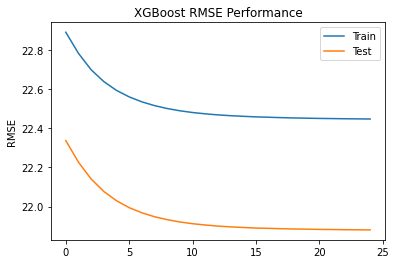


Model building complete!


In [54]:
model_xgb, cv_score, r2_S = fit_model_xgb(model_xgb, y_train, X_train, y_validation, X_validation, column_names)


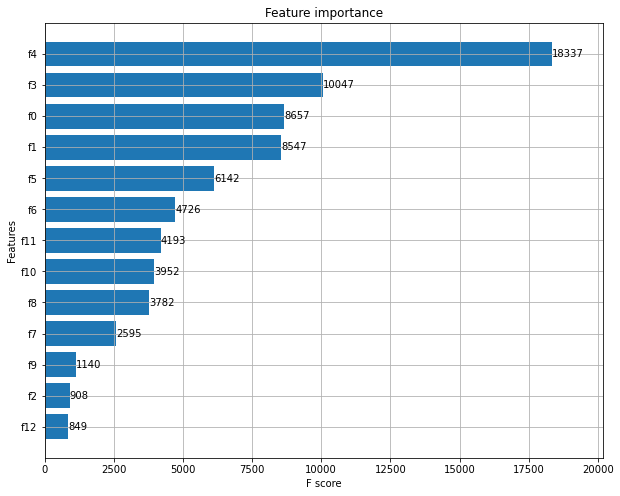

In [55]:
fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(model_xgb, max_num_features=20, height=0.8, ax=ax)
plt.show()

### 4)  Define a sample of clients that represents a specific agency (Please specify which agency and what were your selection criteria and methodology applied).

In [56]:
sample= train.loc[(train['Agencia_ID'] == 1110)]
sample['Cliente_ID'].nunique()

1882

In [57]:
clientes_agencia = pd.DataFrame({'Adjusted Sales': sample.groupby(
            ['Agencia_ID', 'Cliente_ID'])['Demanda_uni_equil'].sum()}).reset_index()
clientes_agencia

,Agencia_ID,Cliente_ID,Adjusted Sales
0,1110,15766,755
1,1110,16119,461
2,1110,16127,311
3,1110,16505,230
4,1110,16509,111
...,...,...,...
1877,1110,9623503,262
1878,1110,9633076,36
1879,1110,9637989,320
1880,1110,9678222,295


In [58]:
clientes_agencia.describe()

,Agencia_ID,Cliente_ID,Adjusted Sales
count,1882.0,1.882000e+03,1882.000000
mean,1110.0,2.484243e+06,396.635494
std,0.0,1.816568e+06,1293.658570
min,1110.0,1.576600e+04,0.000000
25%,1110.0,9.200232e+05,26.000000
50%,1110.0,2.190133e+06,100.000000
75%,1110.0,4.401792e+06,317.000000
max,1110.0,9.733300e+06,36167.000000


In [59]:
sigma_2=clientes_agencia.var()['Adjusted Sales']

v_x= (sigma_2/500)*((1882-500)/1882)
epsilon=1.969*(v_x ** (0.5))
epsilon

97.61680654054

In [60]:
#Calculo del tamaño de muestra

n= sigma_2/((epsilon**(2))/4)
n

702.5061643506803

In [61]:
#Se selecciona un tamaño de muestra de 703 y se utiliza un muestreo aleatorio
cli_age_sample=clientes_agencia.sample(n=703, random_state=1)
cli_age_sample

,Agencia_ID,Cliente_ID,Adjusted Sales
1347,1110,4345219,70
1868,1110,4748726,4
887,1110,2012496,101
650,1110,1353432,21
102,1110,41299,4247
...,...,...,...
50,1110,23659,573
262,1110,159944,316
921,1110,2060911,70
1036,1110,2339772,1746


In [62]:
sample_final=train.loc[train['Cliente_ID'].isin(cli_age_sample.loc[:,'Cliente_ID'])]
sample_final

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,NombreProducto,Producto,Piezas,Peso,Marca,NombreCliente,Client_Type,Town,State
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3,Roles Canela 2p 120g BIM 1212,roles canela,2.0,120.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4,Roles Glass 2p 135g BIM 1216,roles glass,2.0,135.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4,Panquecito Gota Choc 2p 140g BIM 1238,panquecito gota choc,2.0,140.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4,Mantecadas Vainilla 4p 125g BIM 1240,mantecadas vainilla,4.0,125.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3,Donitas Espolvoreadas 6p 105g BIM 1242,donitas espolvoreadas,6.0,105.0,BIM,PUESTO DE PERIODICOS LAZARO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6785599,8,1113,4,1852,4197518,35896,6,79.80,0,0.0,6,Bimkingo Deli 150g MTA LON 35896,bimkingo deli,NaN,150.0,LON,NO IDENTIFICADO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
6785600,8,1113,4,1852,4197518,35898,8,136.00,0,0.0,8,Sandwich Clasico Deli 169g MTA LON 35898,sandwich clasico deli,NaN,169.0,LON,NO IDENTIFICADO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
6785601,8,1113,4,1852,4197518,42084,20,345.00,0,0.0,20,Sandwich Doble Fibra 187g MTA LON 42084,sandwich doble fibra,NaN,187.0,LON,NO IDENTIFICADO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."
6785602,8,1113,4,1852,4197518,42087,30,517.50,0,0.0,30,Sandwich Linaza 179g MTA LON 42087,sandwich linaza,NaN,179.0,LON,NO IDENTIFICADO,Otros,2008 AG. LAGO FILT,"MÉXICO, D.F."


### 5) Predict week 9 for the top 3 selled products in your client sample.

In [63]:
#Mostrar productos mas vendidos
p_mvendidos = pd.DataFrame({'Ventas': sample_final.groupby(['Producto_ID'])['Demanda_uni_equil'].sum()}).reset_index()
p_mvendidos = p_mvendidos.sort_values(by = 'Ventas', ascending = False)
p_mvendidos

,Producto_ID,Ventas
59,2604,37796
165,33794,34214
44,1250,16633
252,47336,12331
190,35651,12140
...,...,...
166,33853,1
78,5340,1
256,48298,1
133,31584,1


In [64]:
sample_test=test1.loc[test1['Cliente_ID'].isin(cli_age_sample.loc[:,'Cliente_ID'])]
sample_test

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Producto,Piezas,Peso,Marca,Client_Type,Town,State
0,9,1110,7,3301,15766,1212,227,2.0,120.0,1,6,5,2
1,9,1110,7,3301,15766,1238,196,2.0,140.0,1,6,5,2
2,9,1110,7,3301,15766,1240,148,4.0,125.0,1,6,5,2
3,9,1110,7,3301,15766,1242,101,6.0,105.0,1,6,5,2
4,9,1110,7,3301,15766,1250,98,4.0,105.0,1,6,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152367,9,1113,4,1852,4197518,35896,31,NaN,150.0,6,6,5,2
152368,9,1113,4,1852,4197518,35898,240,NaN,169.0,6,6,5,2
152369,9,1113,4,1852,4197518,42084,242,NaN,187.0,6,6,5,2
152370,9,1113,4,1852,4197518,42087,244,NaN,179.0,6,6,5,2


In [65]:
tres_masvendidos=[2604,33794,1250]

In [66]:
sample_test=sample_test.loc[sample_test['Producto_ID'].isin(tres_masvendidos)]
sample_test

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Producto,Piezas,Peso,Marca,Client_Type,Town,State
4,9,1110,7,3301,15766,1250,98,4.0,105.0,1,6,5,2
43,9,1110,7,3301,73650,1250,98,4.0,105.0,1,6,5,2
278,9,1110,7,3301,1457784,1250,98,4.0,105.0,1,6,5,2
287,9,1110,7,3301,1603500,1250,98,4.0,105.0,1,6,5,2
301,9,1110,7,3301,1603502,1250,98,4.0,105.0,1,6,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127185,9,1113,1,1116,320029,1250,98,4.0,105.0,1,6,5,2
127250,9,1113,1,1116,1118416,1250,98,4.0,105.0,1,6,5,2
127278,9,1113,1,1116,1279400,1250,98,4.0,105.0,1,6,5,2
127289,9,1113,1,1116,1343861,1250,98,4.0,105.0,1,6,5,2


### Generate predictions for test data

In [67]:
def generate_test_predictions(model, test):
    """ Takes fit XGBOOST model and test data as inputs. 
        Generates and returns model predictions on test data.
    """
    predictions = np.expm1(model.predict(test.values))
    return predictions  

In [68]:
test_predictions = generate_test_predictions(model_xgb, sample_test)  
test_predictions

array([5.0554938e+00, 6.5512600e+00, 6.0909462e+00, 6.4739871e+00,
       6.4739871e+00, 6.4739871e+00, 9.4044552e+00, 6.7527289e+00,
       6.7318521e+00, 7.4781656e+00, 5.0267744e+00, 4.7659321e+00,
       4.7659321e+00, 5.9127703e+00, 6.6966953e+00, 1.1071083e+01,
       6.9398255e+00, 6.4739871e+00, 7.9002194e+00, 6.7527289e+00,
       1.5041424e+01, 2.1720020e+01, 5.9127703e+00, 6.0909462e+00,
       6.7391515e+00, 6.7109776e+00, 2.5274403e+01, 8.1925458e+02,
       5.9127703e+00, 6.5512600e+00, 6.5512600e+00, 6.2361765e+00,
       5.6243281e+00, 6.0909462e+00, 1.0159597e+01, 1.0132239e+01,
       4.7659321e+00, 1.4659498e+01, 6.0909462e+00, 6.0909462e+00,
       6.0909462e+00, 6.4739871e+00, 2.1597145e+01, 6.7109776e+00,
       6.7527289e+00, 6.7318521e+00, 4.7659321e+00, 4.7659321e+00,
       2.5274403e+01, 5.0554938e+00, 1.5041424e+01, 6.7109776e+00,
       5.0554938e+00, 6.0686097e+00, 6.0686097e+00, 6.0909462e+00,
       6.0909462e+00, 6.7427211e+00, 6.0909462e+00, 2.1466339e

In [69]:
Resul=sample_test
Resul['Predicción']=test_predictions
Resul

<ipython-input-69-fd244704ea4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resul['Predicción']=test_predictions


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Producto,Piezas,Peso,Marca,Client_Type,Town,State,Predicción
4,9,1110,7,3301,15766,1250,98,4.0,105.0,1,6,5,2,5.055494
43,9,1110,7,3301,73650,1250,98,4.0,105.0,1,6,5,2,6.551260
278,9,1110,7,3301,1457784,1250,98,4.0,105.0,1,6,5,2,6.090946
287,9,1110,7,3301,1603500,1250,98,4.0,105.0,1,6,5,2,6.473987
301,9,1110,7,3301,1603502,1250,98,4.0,105.0,1,6,5,2,6.473987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127185,9,1113,1,1116,320029,1250,98,4.0,105.0,1,6,5,2,5.897975
127250,9,1113,1,1116,1118416,1250,98,4.0,105.0,1,6,5,2,8.012768
127278,9,1113,1,1116,1279400,1250,98,4.0,105.0,1,6,5,2,8.012768
127289,9,1113,1,1116,1343861,1250,98,4.0,105.0,1,6,5,2,8.012768
